In [1]:
import numpy as np
import matplotlib.pyplot as plt

import utilities

In [44]:
def plot_series(series, time=None, line='-', start=0, end=None, label=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    if time is None:
        time = range(len(series))
    ax.plot(time[start:end], series[start:end], line, label=label)
    utilities.set_ax(ax, xlabel='Time', legend=label is not None, grid=True)

In [3]:
def trend(time, slope=0):
    return slope * time

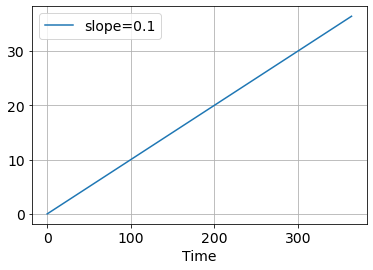

In [4]:
time = np.arange(365)
slope = 0.1
s_trend = trend(time, slope=slope)
plot_series(s_trend, time, label=f'slope={slope:.3g}')

In [5]:
pattern = lambda t: np.where(t < 0.4, np.cos(2*np.pi*t), np.exp(-3*t))

def pattern2series(pattern, time, period, amp=1, phase=0):
    return amp*pattern((time/period + phase) % 1)

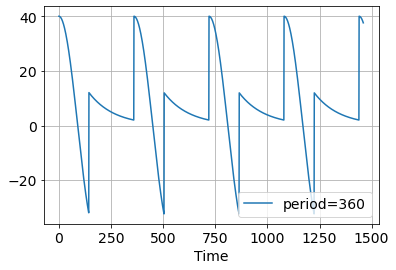

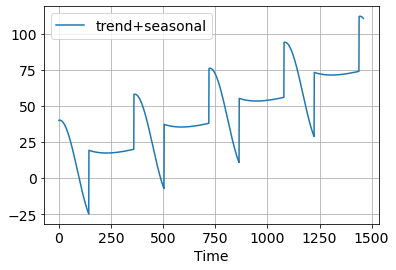

In [6]:
period = 360
time = np.arange(4*365 + 1)

s_season = pattern2series(pattern, time, period, amp=40)
plot_series(s_season, time, label=f'period={period}')

s_ts = s_season + trend(time, 0.05)
plot_series(s_ts, time, label='trend+seasonal')

In [7]:
def noise(time, noise_std=1, rng=np.random.RandomState(0)):
    return rng.randn(len(time)) * noise_std

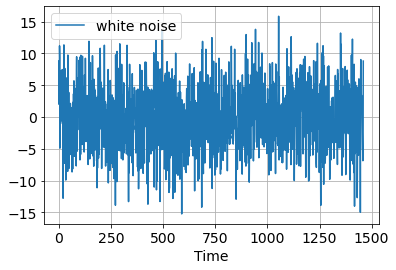

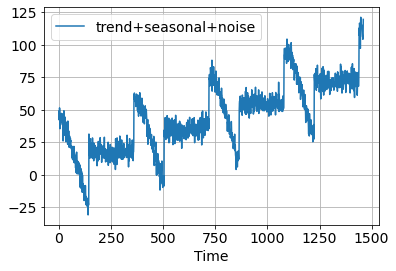

In [8]:
s_noise = noise(time, noise_std=5)
plot_series(s_noise, time, label='white noise')

s_tsn = s_ts + s_noise
plot_series(s_tsn, time, label='trend+seasonal+noise')

In [9]:
def autocor(time, lags, coefs, noise_std=1, ini=0, rng=np.random.RandomState(0)):
    maxlag = max(lags)
    s = rng.randn(maxlag + len(time)) * noise_std
    s[:maxlag] += ini
    for i in range(maxlag, maxlag + len(time)):
        s[i] += sum(c*s[i-lag]for lag, c in zip(lags, coefs))
    return s[maxlag:]

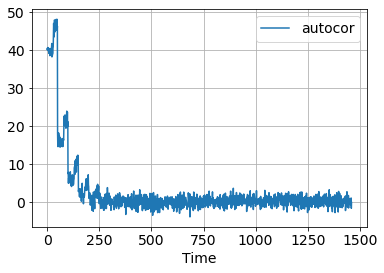

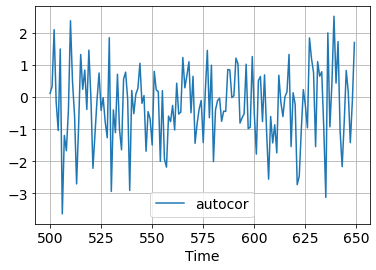

In [10]:
s_ac = autocor(time, lags=[30, 50], coefs=[-0.1, 0.5], ini=100)
plot_series(s_ac, time, label='autocor')
plot_series(s_ac, time, start=500, end=650, label='autocor')

In [11]:
def autocor2(time, coef, noise_std=1, rng=np.random.RandomState(0)):
    s = rng.randn(len(time)) * noise_std
    for i in range(1, len(time)):
        s[i] += coef * s[i-1]
    return s

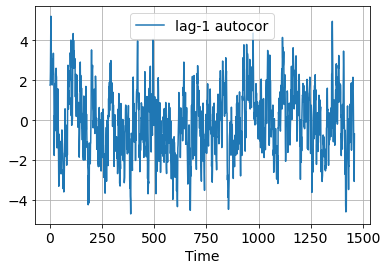

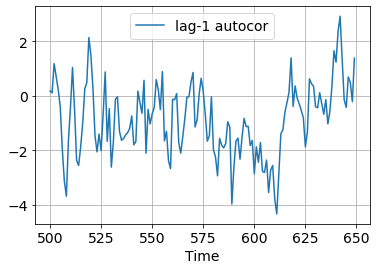

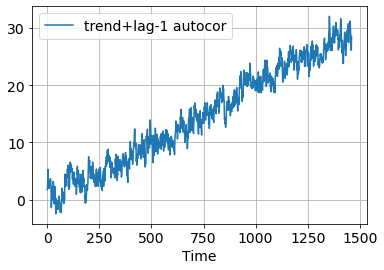

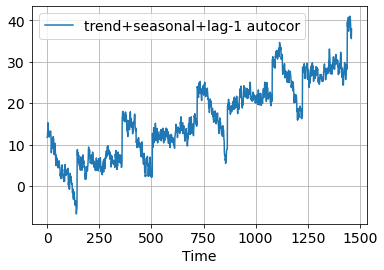

In [12]:
s_ac2 = autocor2(time, 0.8)
plot_series(s_ac2, time, label='lag-1 autocor')
plot_series(s_ac2, time, start=500, end=650, label='lag-1 autocor')
plot_series(s_ac2 + trend(time, 0.02), time, label='trend+lag-1 autocor')
plot_series(s_ac2 + trend(time, 0.02) + pattern2series(pattern, time, period, amp=10),
            time, label='trend+seasonal+lag-1 autocor')

In [13]:
def impulse(time, num, amp=1, rng=np.random.RandomState(0)):
    ind = rng.choice(np.arange(len(time)), num, replace=False)
    s = np.zeros_like(time, dtype=np.float64)
    s[ind] += rng.rand(num) * amp
    return s

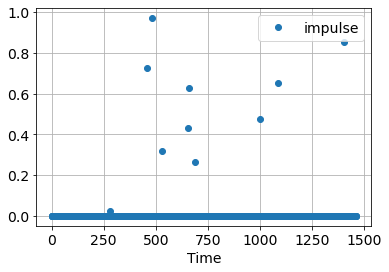

In [14]:
s_imp = impulse(time, 10)
plot_series(s_imp, time, line='o', label='impulse')

In [15]:
def autocor3(series, lagcoef):
    s = series.copy()
    for i, _ in enumerate(s):
        s[i] += sum(coef * s[i-lag] for lag, coef in lagcoef.items() if i >= lag)
    return s

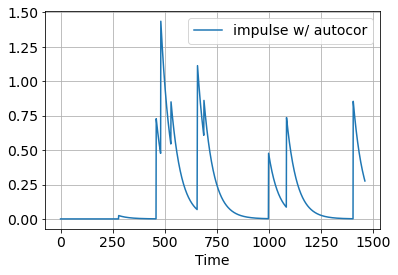

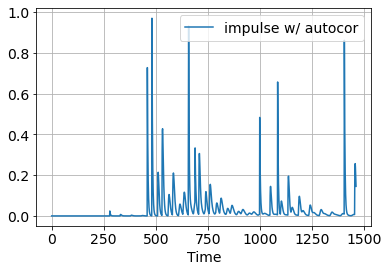

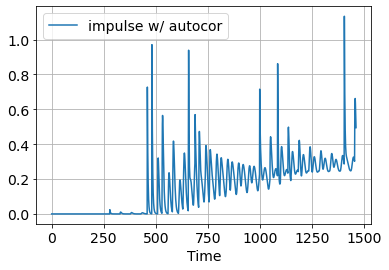

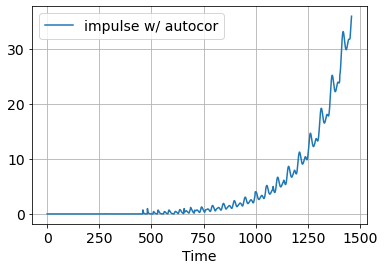

In [16]:
s_autoimp = autocor3(s_imp, {1: 0.98})
plot_series(s_autoimp, time, label='impulse w/ autocor')

s_autoimp = autocor3(s_imp, {1: 0.7, 50: 0.2})
plot_series(s_autoimp, time, label='impulse w/ autocor')

s_autoimp = autocor3(s_imp, {1: 0.7, 50: 0.3})
plot_series(s_autoimp, time, label='impulse w/ autocor')

s_autoimp = autocor3(s_imp, {1: 0.7, 50: 0.4})
plot_series(s_autoimp, time, label='impulse w/ autocor')

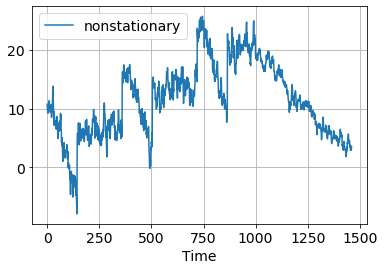

In [17]:
s = autocor2(time, 0.8) + pattern2series(pattern, time, period, amp=10) + trend(time, 0.02)
s2 = autocor2(time, 0.9, noise_std=0.5) + trend(time, -0.04)
plot_series(np.hstack([s[:1000], s2[1000:]+60]), time, label='nonstationary')

In [30]:
import tensorflow as tf
from tensorflow import keras

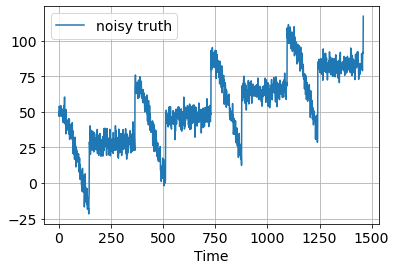

In [19]:
time = np.arange(4*365 + 1.)
baseline = 10
amp = 40
slope = 0.05
noise_std = 5

series = (baseline + trend(time, slope)
          + pattern2series(pattern, time, period=365, amp=amp)
          + noise(time, noise_std=noise_std))
plot_series(series, time, label='noisy truth')

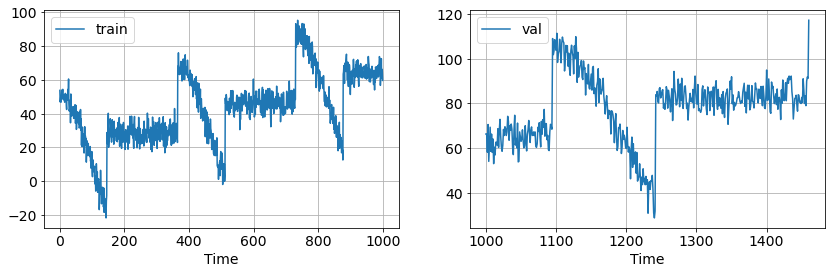

In [48]:
train_len = 1000

train_t, val_t = time[:train_len], time[train_len:]
train_s, val_s = series[:train_len], series[train_len:]

fig, axs = plt.subplots(1, 2, figsize=[14, 4])
plot_series(train_s, train_t, label='train', ax=axs[0])
plot_series(val_s, val_t, label='val', ax=axs[1])

In [78]:
def get_err(s_true, s_pred):
    rmse = np.sqrt(keras.metrics.mean_squared_error(s_true, s_pred))
    mae = keras.metrics.mean_absolute_error(s_true, s_pred).numpy()
    return rmse, mae

def try_pred(train_s, val_s, pred, name='pred', **kwargs):
    pred_s = pred(train_s, val_s, **kwargs)
    rmse, mae = get_err(val_s, pred_s)
    fig, axs = plt.subplots(1, 2, figsize=[14, 4])
    plot_series(np.c_[val_s, pred_s], val_t,
                label=('truth', f'{name}: rmse={rmse:.3g}, mae={mae:.3g}'), ax=axs[0])
    plot_series(np.c_[val_s, pred_s], val_t, end=150, label=('truth', name), ax=axs[1])

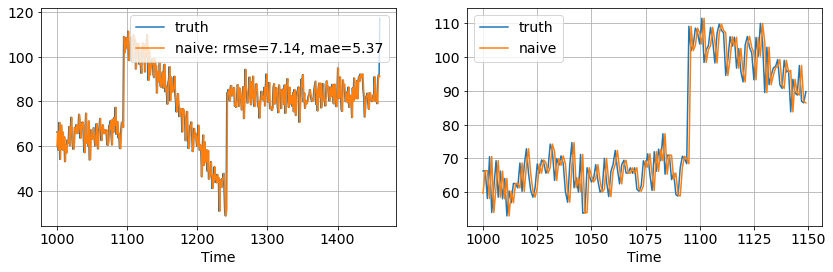

In [79]:
def pred_naive(train_s, val_s):
    return np.r_[train_s[-1], val_s[:-1]]

try_pred(train_s, val_s, pred_naive, 'naive')

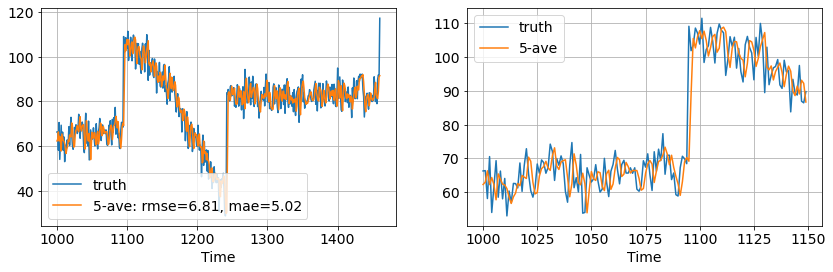

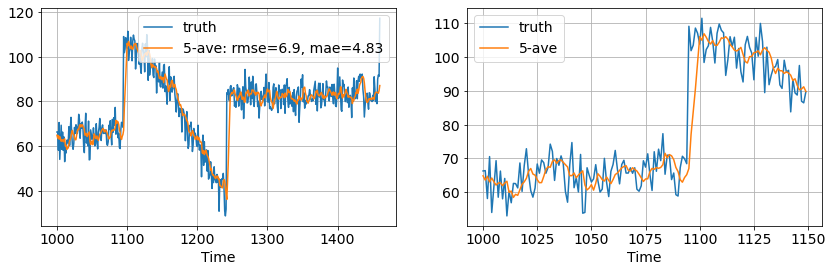

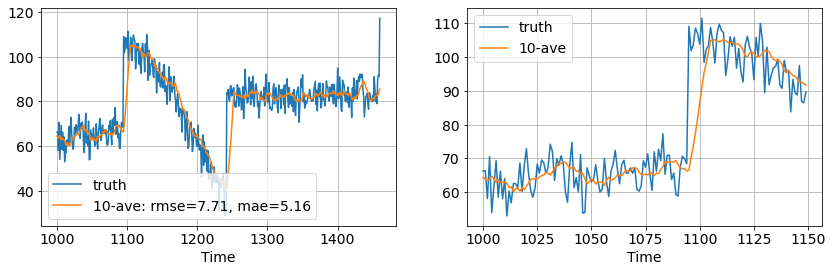

In [53]:
def pred_ave(train_s, val_s, window=1):
    data = np.r_[train_s[-window:], val_s[:-1]]
    pred = np.zeros_like(val_s)
    for i in range(window):
        pred += data[i:i+len(val_s)]/window
    return pred

try_pred(train_s, val_s, pred_ave, '5-ave', window=2)
try_pred(train_s, val_s, pred_ave, '5-ave', window=5)
try_pred(train_s, val_s, pred_ave, '10-ave', window=10)

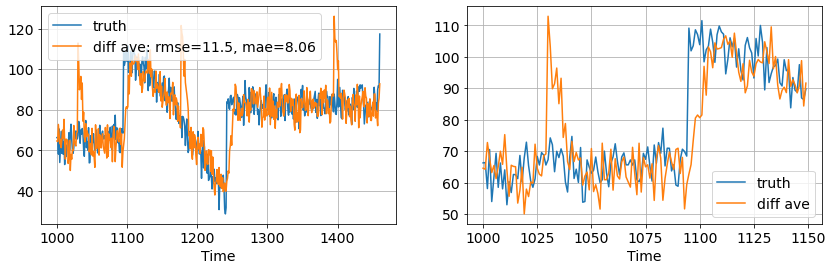

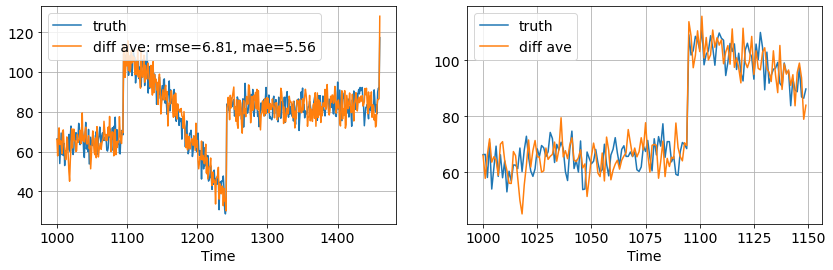

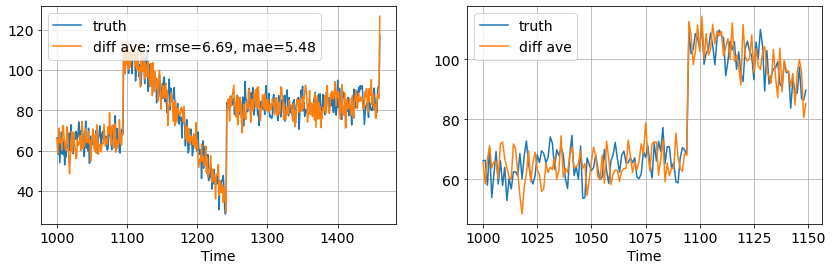

In [60]:
def pred_diff_ave(train_s, val_s, lag=365, window=1):
    data = np.r_[train_s[-(lag+window):], val_s[:-1]]
    diff = data[lag:] - data[:-lag]
    pred = data[window:window+len(val_s)]
    for i in range(window):
        pred += diff[i:i+len(val_s)]/window
    return pred

try_pred(train_s, val_s, pred_diff_ave, name='diff ave', lag=300, window=10)
try_pred(train_s, val_s, pred_diff_ave, name='diff ave', lag=365, window=10)
try_pred(train_s, val_s, pred_diff_ave, name='diff ave', lag=365, window=30)

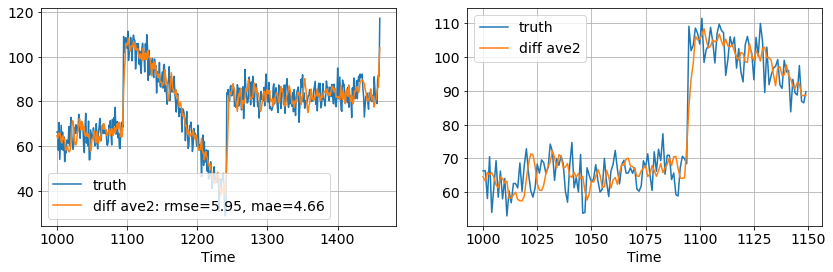

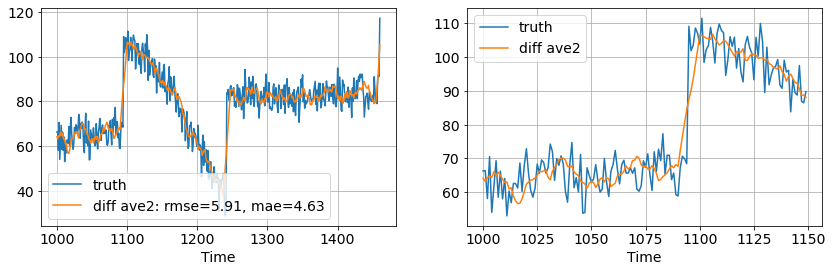

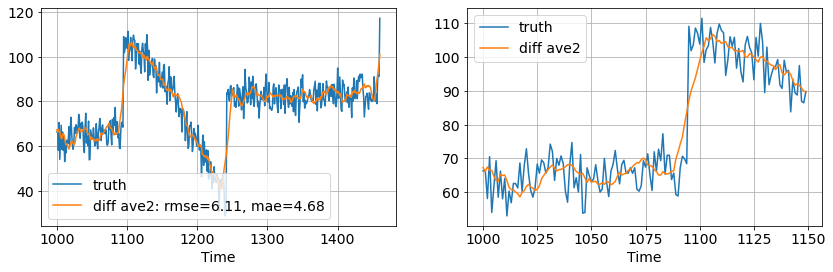

In [66]:
def pred_diff_ave2(train_s, val_s, lag=365, window=1):
    data = np.r_[train_s[-(lag+window):], val_s[:-1]]
    diff = data[lag:] - data[:-lag]
    pred = np.zeros_like(val_s)
    for i in range(window):
        pred += (data[i+window//2:i+window//2+len(val_s)] + diff[i:i+len(val_s)])/window
    return pred

try_pred(train_s, val_s, pred_diff_ave2, name='diff ave2', lag=365, window=5)
try_pred(train_s, val_s, pred_diff_ave2, name='diff ave2', lag=365, window=10)
try_pred(train_s, val_s, pred_diff_ave2, name='diff ave2', lag=365, window=15)